In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tqdm

from utilities.BTTools import groupSpeechesByDiscussionTitle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# get speeches
# setup topic-model
# generate web-page
# implement click-handler

In [3]:
def get_speeches():
    speeches = []
    with open('../../bundestagsreden parser/speeches_20.jsonl', 'r', encoding='utf8') as fp:
        for line in list(fp):
            speeches.append(json.loads(line))

    return speeches

In [4]:
original_speeches = get_speeches()
print(f'loaded {len(original_speeches)}')

loaded 2777


In [5]:
grouped_speeches_by_tops = groupSpeechesByDiscussionTitle(original_speeches)
print(f'grouped speeches to {len(grouped_speeches_by_tops)} "TagesOrnungsPunkten"')

grouped speeches to 208 "TagesOrnungsPunkten"


In [6]:
def get_corpus(tops):
    corpus = []

    for top in tops.values():
        aggregate = []

        for speech in top:
            aggregate.append(speech['text'])
        corpus.append(' '.join(aggregate))

    return corpus

In [7]:
corpus = get_corpus(grouped_speeches_by_tops)
print(f'created corpus with {len(corpus)} entries')

created corpus with 208 entries


In [8]:
nlp = spacy.load('de_core_news_sm')

In [9]:
def corpus_by_POS(corpus, consider):
    groups = []
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        groups.append(' '.join(new_row))

    return groups

In [10]:
consider = ['NOUN']
noun_groups = corpus_by_POS(corpus, consider)

100%|██████████| 208/208 [06:10<00:00,  1.78s/it]


In [11]:
print(f'got {len(noun_groups)} noun_groups')
print(noun_groups[0])

got 208 noun_groups
Herr recht Kollegin Kollege Dame Herr Übernahme Geschäftsordnung Entscheidung Beginn Wahlperiode Geschäftsordnung Grundlage Arbeit Wahlperiode Wahlperiode Tradition Geschäftsordnung Anfang Wahlperiode Mehrheit Stein Wahlperiode Bundestag Geschäftsordnung Dokument Gegebenheit Parlamentarismus Gegebenheit Arbeit Bundestag Geschäftsordnung Entwicklung Wahlperiode Änderung Reform Verhaltensregeln Initiative Präsident Geschäftsordnung Wahlperiode Generalüberholung Impuls Fraktion Weg Vorschlag Opposition Geschäftsordnung Zeit Legislaturperiode Regelung Tag Ausschuß Antrag Absenken Quor Beschlussfähigkeit Bundestag Geschäftsordnung Zustimmung Antrag Weitergeltung Geschäftsordnung Zeit Änderung Dank Beifall abgeordneter GRÜNEN Nächster Wort Beifall Herr Präsident Kollegin Kollege Konstituierung Bundestag Festtag Demokratie Welt Situation Parlament Geschenk Geschenk Kollegin Kollege Beifall abgeordneter GRÜNEN Demokratie Streit Regel Regel Geschäftsordnung Geschäftsordnung 

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.01, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(noun_groups)
feature_names = tfidf_vectorizer.get_feature_names_out()

tf_vectorizer = TfidfVectorizer(vocabulary=feature_names, use_idf=False, norm='l1')
tf_matrix = tf_vectorizer.fit_transform(noun_groups)

c:\python38\lib\site-packages\sklearn\feature_extraction\text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [13]:
print(tfidf_matrix.shape)
print(tf_matrix.shape)

(208, 7548)
(208, 7548)


In [14]:
def create_model(matrix):
    n_topics = 15
    m = NMF(n_components=n_topics)
    m.fit(tfidf_matrix)

    return m

In [15]:
model = create_model(tfidf_matrix)

c:\python38\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [16]:
def get_topic_word_lists(topic_model):
    n_words = 10
    n_words_features = 100

    topic_list = []
    extended_topic_list = []
    topic_words = []

    for idx, topic in enumerate(model.components_):
        top_n = [feature_names[i] for i in topic.argsort()[-n_words:]][::-1]
        top_features = ' '.join(top_n)
        topic_list.append(f"topic_{'_'.join(top_n[:3])}")
        extended_topic_list.append(top_features)

        top_n = [feature_names[i] for i in topic.argsort()[-n_words_features:]][::-1]

        topic_words.append(top_n)

        print(f"Topic {idx}: {top_features}")

    return topic_list, extended_topic_list, topic_words

In [17]:
tl, etl, tw = get_topic_word_lists(model)
print(f'got {len(tl)} topics, {len(etl)} extended topics and {len(tw)} words.')

Topic 0: Energie Gas Ausbau Atomkraftwerk Strom Energieversorgung Erneuerbar Versorgungssicherheit Klimaschutz EEG
Topic 1: Krieg Russland Putin Bundeskanzler Waffe Frieden Präsident Partner Demokratie NATO
Topic 2: Impfpflicht Impfung Pflege Pandemie Variante Impfstoff Genesenenstatus Pflegekraft Impfquot Antrag
Topic 3: Mandat Mission Soldat Einsatz Soldatinn Operation Bundeswehr Schiff Region Nation
Topic 4: Euro Milliarde Haushalt Nachtragshaushalt Investition Pandemie Krise Wirtschaft Geld Mittel
Topic 5: Kind Kommune Ganztagsbetreuung Schule Familie Geflüchtet Bund Registrierung Bildung jugendliche
Topic 6: Landwirt Landwirtschaft Ernährung Künast Lebensmittel Hunger Bauer Fläche Betrieb Million
Topic 7: Inflation Euro Entlastung Preis Einkommen Energiepreis Bürger Progression Maßnahme Rentner
Topic 8: Opfer Anschlag Sicherheitsbehörde Antrag Rechtsextremismus Demokratie Rechtsstaat Extremismus Straftat Verfassungsschutz
Topic 9: Gesetzentwurf Maßnahme Pandemie Gesetz Infektionss

In [18]:
topic2word = model.components_ # TW
doc2topic = (tf_matrix * topic2word.T) # TN

print(f'tf_matrix: {tf_matrix.shape}')
print(f'topic2word: {topic2word.shape}')
print(f'doc2topic: {doc2topic.shape}')

tf_matrix: (208, 7548)
topic2word: (15, 7548)
doc2topic: (208, 15)


In [19]:
def get_topic2_topic(tm):
    normalized_matrix = normalize(tm.components_, axis=1, norm='l1')
    print(f'normalized_matrix: {normalized_matrix.shape}')

    topic_to_topic = cosine_similarity(normalized_matrix)
    print(f'topic2topic: {topic_to_topic.shape}')

    return topic_to_topic

normalized_matrix: (15, 7548)
topic2topic: (15, 15)


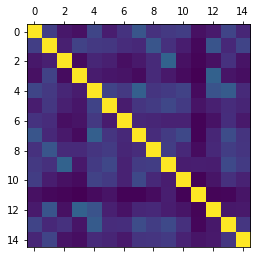

In [20]:
topic2topic = get_topic2_topic(model)

plt.matshow(topic2topic)
plt.show()

In [21]:
def create_topic2topic_graph(t2t, extended_topic_list):
    nodes = []
    count = 1

    for i, topic in enumerate(t2t):
        nodes.append({
            'id': count,
            'topicname': extended_topic_list[i]
        })
        count += 1

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': nodes
    }

    for i, node_i in enumerate(graph['nodes']):
        for j, node_j in enumerate(graph['nodes']):
            if i < j:
                source = node_i['id']
                target = node_j['id']
                weight = t2t[i, j]
                if weight > 0.15:
                    link = {
                        'source': source,
                        'target': target,
                        'weight': weight
                    }
                    graph['links'].append(link)

    return graph

In [22]:
t2t_graph = create_topic2topic_graph(topic2topic, etl)

print(f"got a graph with {len(t2t_graph['nodes'])} nodes.")
print('the first node:')
print(t2t_graph['nodes'][0])

got a graph with 15 nodes.
the first node:
{'id': 1, 'topicname': 'Energie Gas Ausbau Atomkraftwerk Strom Energieversorgung Erneuerbar Versorgungssicherheit Klimaschutz EEG'}


In [23]:
def get_graph_template(graph, properties):
    node_label = properties['nodelabel']
    node_coloring = properties['nodecoloring']

    lv = '//' if properties['edgevisibility'] else ''
    parts = '//' if not properties['particles'] else ''
    dm = '//' if not properties['darkmode'] else ''

    d3graph = {
        'nodes': graph['nodes'],
        'links': graph['links']
    }

    htmlcode = f"""<head>
        <style>
            body {{
                margin: 0;
                font-family: Arial;
            }}
            h3 {{text-align: center;}}
            .center {{
              display: block;
              margin-left: auto;
              margin-right: auto;
            }}
        </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="Logo.png" height="150" width="300" class="center">
    <h3>DebSearch ist eine statistische Website, welche die aktuelle Legislaturperiode</h3>
    <h3>in verschiedenen Kategorieren auswertet und visualisiert.</h3>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{node_label}')
            .nodeRelSize(3)
            .nodeVal('nReden')
            .nodeAutoColorBy('{node_coloring}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            .onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """

    return { 'graph': htmlcode }

In [24]:
properties = {
    'nodecoloring':'topicname',
    'nodelabel': 'topicname',
    "darkmode": False,
    "edgevisibility": True,
    "particles": False
}

html_graph = get_graph_template(t2t_graph, properties)

In [25]:
def write_html_file(html):
    with open(f'./topic_network.html', 'w') as f:
        f.write(html['graph'])

In [26]:
write_html_file(html_graph)